# Hydrofabric usage demo

This notebook shows how we can use the Hydrofabric datasource to make queries of interest.  This demo assumes that the raw Hydrofabric GPKG has been loaded into a SQL database called `hydrofabric` on a PostGIS-enabled database server, and that the environment variables `PGHOST`, `PGUSER`, and `PGPASSWORD` are set.

In [1]:
import os
from functools import partial

import fiona
import geopandas as gp
import pandas as pd
import psycopg2 as pg
from psycopg2 import sql
import pyproj
from shapely.geometry import shape, Point, GeometryCollection
from shapely import wkb
from shapely.ops import transform, unary_union

In [2]:
def single_query(query_str):
    with pg.connect(dbname="hydrofabric") as conn:
        with conn.cursor() as cur:
            cur.execute(sql.SQL(query_str))
            return cur.fetchone()

In [3]:
def multiple_query(query_str):
    with pg.connect("dbname=hydrofabric") as conn:
        with conn.cursor() as cur:
            cur.execute(sql.SQL(query_str))
            return cur.fetchall()

In [4]:
def get_schema(table):
    with pg.connect(dbname='hydrofabric') as conn:
        with conn.cursor() as cur:
            cur.execute(sql.SQL(f"""
                SELECT column_name, data_type, is_nullable
                FROM information_schema.columns
                WHERE table_name = '{table}'
            """))
            return cur.fetchall()

casts = { 
    'integer': lambda x: int(x), 
    'character varying': lambda s: str(s), 
    'double precision': lambda x: float(x), 
    'USER-DEFINED': lambda s: wkb.loads(bytes.fromhex(s)) 
}

def query_to_dataframe(query, schema_from, geom_col='geom'):
    data = multiple_query(query)
    schema = get_schema(schema_from)
    data = [ [casts[typ](datum) for (datum, (name, typ, nul)) in zip(row, schema)] for row in data]
    return gp.GeoDataFrame(
        data, 
        columns = list(map(lambda x: x[0], schema)),
        geometry = geom_col
    )

## Pull AOI

In [5]:
!wget -O montco.geojson 'https://opendata.arcgis.com/api/v3/datasets/b3d5b14c0a954623b9626c5ed3ca82f1_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1'

--2022-12-07 18:23:12--  https://opendata.arcgis.com/api/v3/datasets/b3d5b14c0a954623b9626c5ed3ca82f1_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1
Resolving opendata.arcgis.com (opendata.arcgis.com)... 44.207.123.71, 34.193.115.202, 3.219.120.199
Connecting to opendata.arcgis.com (opendata.arcgis.com)|44.207.123.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘montco.geojson’

montco.geojson          [ <=>                ]  58.96K  --.-KB/s    in 0.001s  

2022-12-07 18:23:12 (90.1 MB/s) - ‘montco.geojson’ saved [60375]



In [6]:
!ogr2ogr montco_conus.geojson -t_srs "EPSG:5070" montco.geojson

Montgomery County


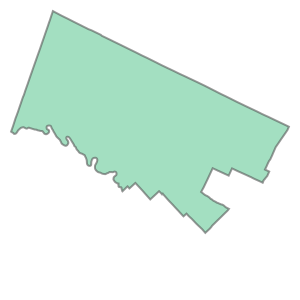

In [7]:
with fiona.open('montco_conus.geojson') as source:
    for f in source:
        print(f['properties']['Name'])
        g5070 = shape(f['geometry'])
g5070

## Example queries

In this section, we consider the administrative boundary given above and extend it to be more hydrologically-relevant by extending the region to include all the catchments that intersect it.  We then show some simple queries against this region.

In [8]:
dilate_query = f"""
  WITH all_divides as (
      SELECT geom
      FROM divides
      WHERE ST_Intersects(geom, ST_SetSRID('{g5070.wkt}'::geometry, 5070))
  ) SELECT ST_Union(geom)
    FROM all_divides
  """

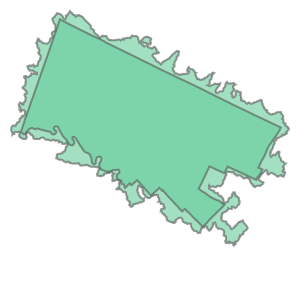

In [9]:
union_geom = wkb.loads(bytes.fromhex(single_query(dilate_query)[0]))
GeometryCollection([union_geom, g5070])

In [10]:
flowpath_query = f"""
  WITH reaches as (
    SELECT 
      geom,
      toid AS sink_nexus,
      ST_Intersects(geom, ST_SetSRID('{union_geom.boundary.buffer(10).wkt}'::geometry, 5070)) AS boundary
    FROM flowpaths
    WHERE ST_Covers(ST_SetSRID('{union_geom.wkt}'::geometry, 5070), geom) 
  ) SELECT
      r.geom,
      r.boundary,
      ST_Intersects(n.geom, ST_SetSRID('{union_geom.boundary.buffer(10).wkt}'::geometry, 5070)) as outflow
    FROM reaches r
    JOIN nexus n
    ON r.sink_nexus = n.id
"""

In [11]:
flowpaths = gp.GeoDataFrame(
    [(wkb.loads(bytes.fromhex(geom)), bound, out) for (geom, bound, out) in multiple_query(flowpath_query)],
    columns=['geom', 'boundary', 'outflow'],
    geometry='geom'
)

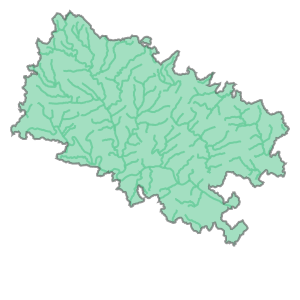

In [12]:
GeometryCollection([
    unary_union(list(flowpaths.geom)),
    union_geom
])

In [13]:
crosswalk_query = f"""
  WITH aoi_divides as (
      SELECT toid
      FROM divides
      WHERE ST_Intersects(geom, ST_SetSRID('{g5070.wkt}'::geometry, 5070))
  ), aoi_flowpaths as (
      SELECT geom, f.id, "order"
      FROM flowpaths f
      JOIN aoi_divides d
      ON f.toid = d.toid
  ) SELECT
      f.geom, "order", NHDPlusV2_COMID as comid, NHDPlusV2_COMID_part as part
    FROM aoi_flowpaths f
    JOIN crosswalk c
    ON f.id = c.id
  """

<AxesSubplot:>

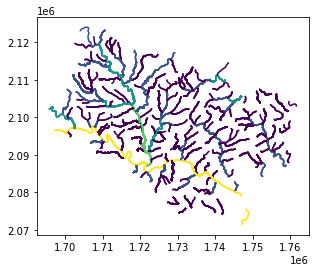

In [14]:
crosswalk = gp.GeoDataFrame(
    [(wkb.loads(bytes.fromhex(geom)), int(order), int(comid), int(part)) for (geom, order, comid, part) in multiple_query(crosswalk_query)],
    columns=['geom', 'order', 'comid', 'part'],
    geometry='geom'
)
crosswalk.plot(column='order')

In [15]:
crosswalk

,geom,order,comid,part
0,"MULTILINESTRING ((1748117.889 2075468.456, 174...",5,4784835,1
1,"MULTILINESTRING ((1726391.124 2087303.867, 172...",5,4782491,1
2,"MULTILINESTRING ((1726391.124 2087303.867, 172...",5,4782491,1
3,"MULTILINESTRING ((1726391.124 2087303.867, 172...",5,4782495,1
4,"MULTILINESTRING ((1726391.124 2087303.867, 172...",5,4782495,1
...,...,...,...,...
1764,"MULTILINESTRING ((1730829.125 2088521.874, 173...",5,4782501,1
1765,"MULTILINESTRING ((1731310.978 2088312.642, 173...",5,4782501,2
1766,"MULTILINESTRING ((1731310.978 2088312.642, 173...",5,4782501,2
1767,"MULTILINESTRING ((1731310.978 2088312.642, 173...",5,4782501,2
